# RMSprop from scratch


In [1]:
from mxnet import ndarray as nd

# RMSProp.
def rmsprop(params, sqrs, lr, gamma, batch_size):
    eps_stable = 1e-8
    for param, sqr in zip(params, sqrs):
        g = param.grad / batch_size
        sqr[:] = gamma * sqr + (1. - gamma) * nd.square(g)
        div = lr * g / nd.sqrt(sqr + eps_stable)
        param[:] -= div

import mxnet as mx
from mxnet import autograd
from mxnet import gluon
import random

mx.random.seed(1)
random.seed(1)

# Generate data.
num_inputs = 2
num_examples = 1000
true_w = [2, -3.4]
true_b = 4.2
X = nd.random_normal(scale=1, shape=(num_examples, num_inputs))
y = true_w[0] * X[:, 0] + true_w[1] * X[:, 1] + true_b
y += .01 * nd.random_normal(scale=1, shape=y.shape)
dataset = gluon.data.ArrayDataset(X, y)


# Construct data iterator.
def data_iter(batch_size):
    idx = list(range(num_examples))
    random.shuffle(idx)
    for batch_i, i in enumerate(range(0, num_examples, batch_size)):
        j = nd.array(idx[i: min(i + batch_size, num_examples)])
        yield batch_i, X.take(j), y.take(j)

# Initialize model parameters.
def init_params():
    w = nd.random_normal(scale=1, shape=(num_inputs, 1))
    b = nd.zeros(shape=(1,))
    params = [w, b]
    sqrs = []
    for param in params:
        param.attach_grad()
        sqrs.append(param.zeros_like())
    return params, sqrs

# Linear regression.
def net(X, w, b):
    return nd.dot(X, w) + b

# Loss function.
def square_loss(yhat, y):
    return (yhat - y.reshape(yhat.shape)) ** 2 / 2

In [2]:
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 120
import matplotlib.pyplot as plt
import numpy as np

def train(batch_size, lr, gamma, epochs, period):
    assert period >= batch_size and period % batch_size == 0
    [w, b], sqrs = init_params()
    total_loss = [np.mean(square_loss(net(X, w, b), y).asnumpy())]

    # Epoch starts from 1.
    for epoch in range(1, epochs + 1):
        for batch_i, data, label in data_iter(batch_size):
            with autograd.record():
                output = net(data, w, b)
                loss = square_loss(output, label)
            loss.backward()
            rmsprop([w, b], sqrs, lr, gamma, batch_size)
            if batch_i * batch_size % period == 0:
                total_loss.append(np.mean(square_loss(net(X, w, b), y).asnumpy()))
        print("Batch size %d, Learning rate %f, Epoch %d, loss %.4e" % 
              (batch_size, lr, epoch, total_loss[-1]))
    print('w:', np.reshape(w.asnumpy(), (1, -1)), 
          'b:', b.asnumpy()[0], '\n')
    x_axis = np.linspace(0, epochs, len(total_loss), endpoint=True)
    plt.semilogy(x_axis, total_loss)
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.show()

Batch size 10, Learning rate 0.030000, Epoch 1, loss 7.5963e-01
Batch size 10, Learning rate 0.030000, Epoch 2, loss 1.4048e-04
Batch size 10, Learning rate 0.030000, Epoch 3, loss 1.1444e-04
w: [[ 2.003901  -3.3957026]] b: 4.20971 



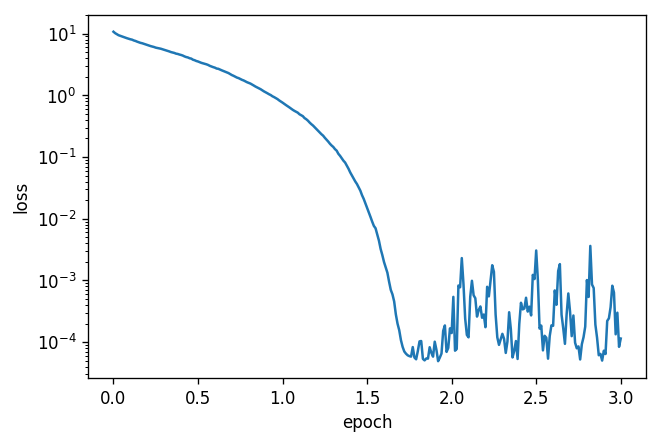

In [3]:
train(batch_size=10, lr=0.03, gamma=0.9, epochs=3, period=10)

## Next
[RMSProp with Gluon](../chapter06_optimization/rmsprop-gluon.ipynb)

For whinges or inquiries, [open an issue on  GitHub.](https://github.com/zackchase/mxnet-the-straight-dope)